# Run DESeq2 and Ashr on random intron screen count data

created 4/24/24, last modified 6/6/24

In [1]:
suppressPackageStartupMessages({
  library("DESeq2")
  library("ashr")
  library("ggplot2")
})

Warning message:
“package ‘DESeq2’ was built under R version 4.3.3”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.3”


In [2]:
IME_path <- '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/data/'

data_path <- paste0(IME_path, 'integrated_GFP_dTom_counts.csv')
info_path <- paste0(IME_path, 'integrated_experiment_info.csv')

df <- read.csv(data_path, row.names=1)
experiment_info <- read.csv(info_path)

In [3]:
coldata<-experiment_info

coldata$reporter<-factor(coldata$reporter)
coldata$replicate<-factor(coldata$replicate)
coldata$run<-factor(coldata$run)
coldata$transfection<-factor(coldata$transfection)

In [4]:
dds <- DESeqDataSetFromMatrix(countData = df,
                              colData = coldata,
                              design = ~ replicate + reporter)

dds<-estimateSizeFactors(dds)
norm.cts<-counts(dds, normalized=TRUE)

dds<-DESeq(dds)
vst_data <- vst(dds, blind=FALSE)
res <- results(dds, alpha=0.1)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [5]:
summary(res)


out of 19346 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 551, 2.8%
LFC < 0 (down)     : 291, 1.5%
outliers [1]       : 0, 0%
low counts [2]     : 751, 3.9%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



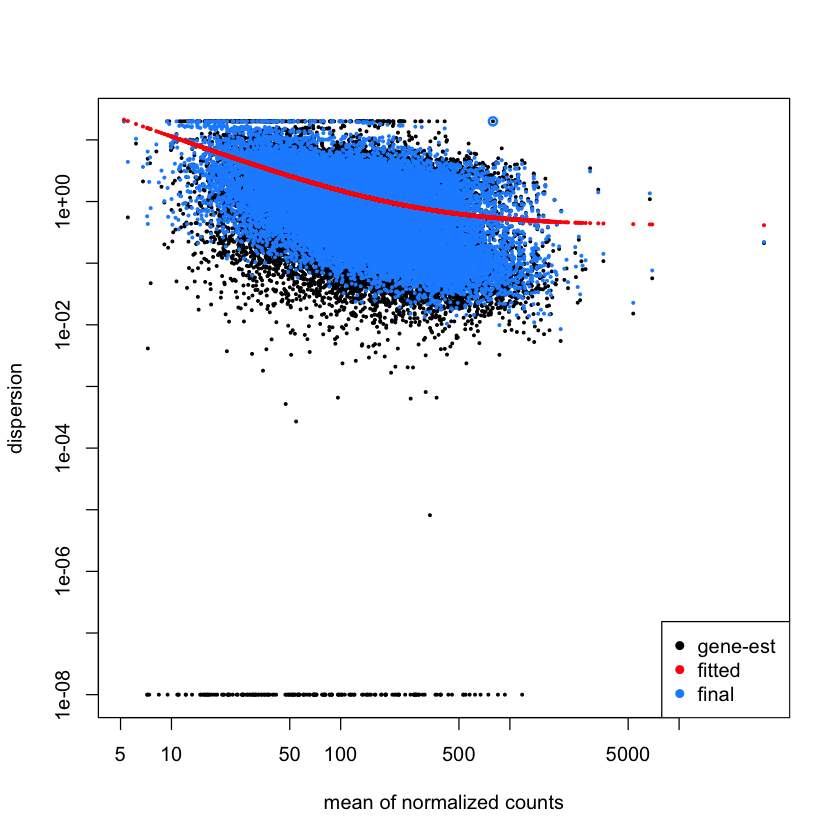

In [6]:
plotDispEsts(dds)

In [7]:
res

log2 fold change (MLE): reporter GFP vs dTOM 
Wald test p-value: reporter GFP vs dTOM 
DataFrame with 19346 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
CCAACATAATAAATCATA   39.2379       1.478257  1.296092  1.140549   0.2540575
CACAATTAATACTCTAAC  455.5581       1.780290  1.285492  1.384909   0.1660803
AAACCATCCACACTTACA   68.1602       0.668577  0.609186  1.097491   0.2724266
ATACCCTATACTCACAAT  226.9210       0.398765  0.556141  0.717021   0.4733611
ACCCTCCAAATCCACATA   52.5362       1.223715  0.604343  2.024869   0.0428808
...                      ...            ...       ...       ...         ...
ACTATCTAACCAAACACA   351.752      -3.450674  0.821808  -4.19888 2.68235e-05
ACTCCTTCAATCCCATCA  1835.845      -4.758091  0.803989  -5.91810 3.25678e-09
CATAACTTAATTATTTTA  3328.693      -2.584046  0.862900  -2.99461 2.74799e-03
TACATTATCTCTTCATAC  6715.320      -4.

In [8]:
beta <- res$log2FoldChange
beta_se <- res$lfcSE

ash_res<-ash(beta,beta_se, mixcompdist='halfnormal')

shrunk_results <- ash_res$result

shrunk_results$uncorr_log2FC<-res$log2FoldChange
shrunk_results$uncorr_lfcSE<-res$lfcSE
shrunk_results$uncorr_pval<-res$pvalue
shrunk_results$baseMean<-res$baseMean
shrunk_results$padj<-res$padj

In [9]:
write.csv(norm.cts, paste0(IME_path,"integrated_DESeq2_output_norm_cts.csv"))
write.csv(shrunk_results, paste0(IME_path,"integrated_DESeq2_output_shrunk_results.csv"))

using ntop=500 top features by variance



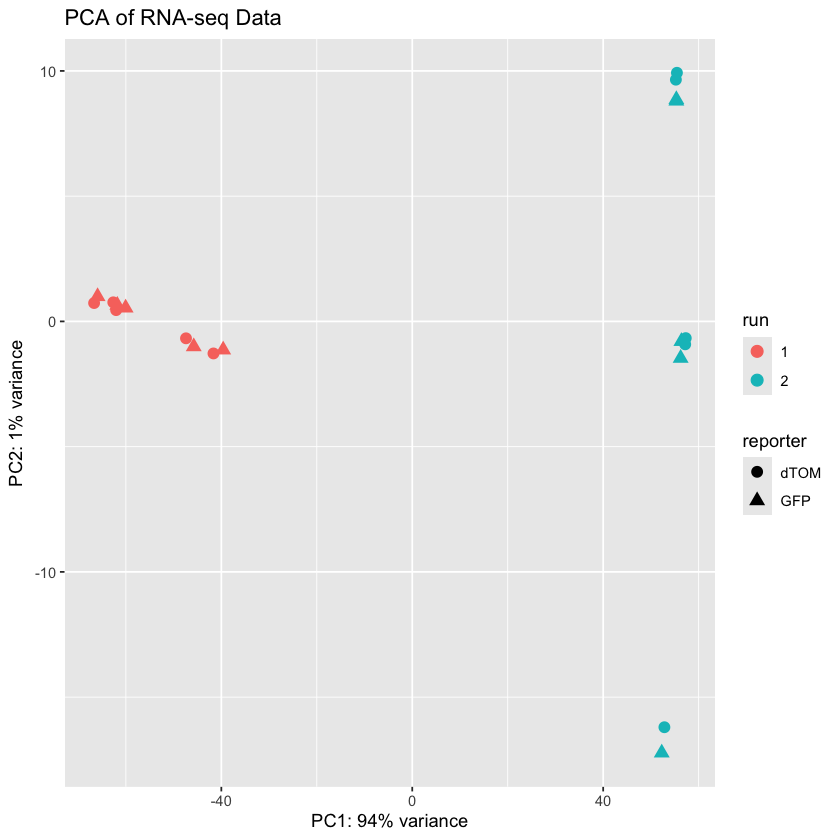

In [10]:
# Perform PCA
pca_res <- plotPCA(vst_data, intgroup=colnames(colData(dds)), returnData=TRUE)
percentVar <- round(100 * attr(pca_res, "percentVar"))

# Plotting the PCA
ggplot(pca_res, aes(PC1, PC2, color=run, shape=reporter)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  ggtitle("PCA of RNA-seq Data")
